# Imports

In [93]:
import copy
import argparse

import os
os.environ["OPENCV_VIDEOIO_MSMF_ENABLE_HW_TRANSFORMS"] = "0"

import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# For FPS
from collections import deque

In [71]:
### MODIFYING Mediapipe Holistics for capturing Shoulder + Arms + Hands only
from mediapipe.python.solutions.drawing_utils import DrawingSpec
from mediapipe.python.solutions.holistic import PoseLandmark

In [72]:
# list of landmarks to include on the image
included_landmarks = [
    # right hand set
    PoseLandmark.RIGHT_SHOULDER,
    PoseLandmark.RIGHT_ELBOW,
    PoseLandmark.RIGHT_WRIST,

    # left hand set
    PoseLandmark.LEFT_SHOULDER,
    PoseLandmark.LEFT_ELBOW,
    PoseLandmark.LEFT_WRIST,
    # thumb, index and pinky are not required, since they are included in hand landmarks
]

In [6]:
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [73]:
# Mostly for FPS calc

class CvFpsCalc(object):
    def __init__(self, buffer_len=1):
        self._start_tick = cv.getTickCount()
        self._freq = 1000.0 / cv.getTickFrequency()
        self._difftimes = deque(maxlen=buffer_len)

    def get(self):
        current_tick = cv.getTickCount()
        different_time = (current_tick - self._start_tick) * self._freq
        self._start_tick = current_tick

        self._difftimes.append(different_time)

        fps = 1000.0 / (sum(self._difftimes) / len(self._difftimes))
        fps_rounded = round(fps, 2)

        return fps_rounded

# Misc funcs

### Hand Landmarks Visualization

In [74]:
def draw_hand_v2(image, hand_landmarks):
    image_width, image_height = image.shape[1], image.shape[0]
    landmark_point = []

    for index, landmark in enumerate(hand_landmarks.landmark):
        if landmark.visibility < 0 or landmark.presence < 0:
            continue

        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_z = landmark.z

        landmark_point.append((landmark_x, landmark_y))

        if index == 0:  # 手首1
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 1:  # 手首2
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 2:  # 親指：付け根
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 3:  # 親指：第1関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 4:  # 親指：指先
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
        if index == 5:  # 人差指：付け根
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 6:  # 人差指：第2関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 7:  # 人差指：第1関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 8:  # 人差指：指先
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
        if index == 9:  # 中指：付け根
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 10:  # 中指：第2関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 11:  # 中指：第1関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 12:  # 中指：指先
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
        if index == 13:  # 薬指：付け根
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 14:  # 薬指：第2関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 15:  # 薬指：第1関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 16:  # 薬指：指先
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)
        if index == 17:  # 小指：付け根
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 18:  # 小指：第2関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 19:  # 小指：第1関節
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
        if index == 20:  # 小指：指先
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.circle(image, (landmark_x, landmark_y), 12, (0, 255, 0), 2)

        # if not upper_body_only:
        if True:
            cv.putText(image, "z:" + str(round(landmark_z, 3)),
                       (landmark_x - 10, landmark_y - 10),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                       cv.LINE_AA)

    # 接続線
    if len(landmark_point) > 0:
        # 親指
        cv.line(image, landmark_point[2], landmark_point[3], (0, 255, 0), 2)
        cv.line(image, landmark_point[3], landmark_point[4], (0, 255, 0), 2)

        # 人差指
        cv.line(image, landmark_point[5], landmark_point[6], (0, 255, 0), 2)
        cv.line(image, landmark_point[6], landmark_point[7], (0, 255, 0), 2)
        cv.line(image, landmark_point[7], landmark_point[8], (0, 255, 0), 2)

        # 中指
        cv.line(image, landmark_point[9], landmark_point[10], (0, 255, 0), 2)
        cv.line(image, landmark_point[10], landmark_point[11], (0, 255, 0), 2)
        cv.line(image, landmark_point[11], landmark_point[12], (0, 255, 0), 2)

        # 薬指
        cv.line(image, landmark_point[13], landmark_point[14], (0, 255, 0), 2)
        cv.line(image, landmark_point[14], landmark_point[15], (0, 255, 0), 2)
        cv.line(image, landmark_point[15], landmark_point[16], (0, 255, 0), 2)

        # 小指
        cv.line(image, landmark_point[17], landmark_point[18], (0, 255, 0), 2)
        cv.line(image, landmark_point[18], landmark_point[19], (0, 255, 0), 2)
        cv.line(image, landmark_point[19], landmark_point[20], (0, 255, 0), 2)

        # 手の平
        cv.line(image, landmark_point[0], landmark_point[1], (0, 255, 0), 2)
        cv.line(image, landmark_point[1], landmark_point[2], (0, 255, 0), 2)
        cv.line(image, landmark_point[2], landmark_point[5], (0, 255, 0), 2)
        cv.line(image, landmark_point[5], landmark_point[9], (0, 255, 0), 2)
        cv.line(image, landmark_point[9], landmark_point[13], (0, 255, 0), 2)
        cv.line(image, landmark_point[13], landmark_point[17], (0, 255, 0), 2)
        cv.line(image, landmark_point[17], landmark_point[0], (0, 255, 0), 2)

    return image

### Shoulders + Arms

In [75]:
def draw_pose_landmarks_v2(
    image,
    landmarks,
    # upper_body_only,
    visibility_th=0.5,
):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_point = []

    for index, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)
        landmark_z = landmark.z
        landmark_point.append([landmark.visibility, (landmark_x, landmark_y)])

        if landmark.visibility < visibility_th:
            continue

        if index in included_landmarks:
            cv.circle(image, (landmark_x, landmark_y), 5, (0, 255, 0), 2)
            cv.putText(image, "z:" + str(round(landmark_z, 3)),
                       (landmark_x - 10, landmark_y - 10),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1,
                       cv.LINE_AA)

    if len(landmark_point) > 0:
        # 肩 - Shoulders
        if landmark_point[11][0] > visibility_th and landmark_point[12][
                0] > visibility_th:
            cv.line(image, landmark_point[11][1], landmark_point[12][1],
                    (0, 255, 0), 2)

        # 右腕 - Right Arm
        if landmark_point[11][0] > visibility_th and landmark_point[13][
                0] > visibility_th:
            cv.line(image, landmark_point[11][1], landmark_point[13][1],
                    (0, 255, 0), 2)
        if landmark_point[13][0] > visibility_th and landmark_point[15][
                0] > visibility_th:
            cv.line(image, landmark_point[13][1], landmark_point[15][1],
                    (0, 255, 0), 2)

        # 左腕 - Left Arm
        if landmark_point[12][0] > visibility_th and landmark_point[14][
                0] > visibility_th:
            cv.line(image, landmark_point[12][1], landmark_point[14][1],
                    (0, 255, 0), 2)
        if landmark_point[14][0] > visibility_th and landmark_point[16][
                0] > visibility_th:
            cv.line(image, landmark_point[14][1], landmark_point[16][1],
                    (0, 255, 0), 2)

        
    return image

### Rect Drawing

In [76]:
def calc_bounding_rect(image, landmarks):
    image_width, image_height = image.shape[1], image.shape[0]

    landmark_array = np.empty((0, 2), int)

    for _, landmark in enumerate(landmarks.landmark):
        landmark_x = min(int(landmark.x * image_width), image_width - 1)
        landmark_y = min(int(landmark.y * image_height), image_height - 1)

        landmark_point = [np.array((landmark_x, landmark_y))]

        landmark_array = np.append(landmark_array, landmark_point, axis=0)

    x, y, w, h = cv.boundingRect(landmark_array)

    return [x, y, x + w, y + h]

In [77]:
def draw_bounding_rect(use_brect, image, brect):
    if use_brect:
        # 外接矩形
        cv.rectangle(image, (brect[0], brect[1]), (brect[2], brect[3]),
                     (0, 255, 0), 2)

    return image

### Prolly unused for the most part

In [96]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is not writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is again writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [97]:
#defining landmarks for each body component
def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

-----

In [10]:
# def get_args():
#     parser = argparse.ArgumentParser()

#     parser.add_argument("--device", type=int, default=0)
#     parser.add_argument("--width", help='cap width', type=int, default=960) # 720
#     parser.add_argument("--height", help='cap height', type=int, default=720) # 540

#     parser.add_argument('--unuse_smooth_landmarks', action='store_true')
#     parser.add_argument("--model_complexity",
#                         help='model_complexity(0,1(default),2)',
#                         type=int,
#                         default=1)
#     parser.add_argument("--min_detection_confidence",
#                         help='face mesh min_detection_confidence',
#                         type=float,
#                         default=0.5)
#     parser.add_argument("--min_tracking_confidence",
#                         help='face mesh min_tracking_confidence',
#                         type=int,
#                         default=0.5)


#     parser.add_argument('--use_brect', action='store_true',
#                         default=True)


#     args = parser.parse_args()

#     return args

In [78]:
# LIVE FEED
# args = get_args()

cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = True

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

### OLD VER
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     while cap.isOpened():
#         ret, frame = cap.read()
#         image, results = mediapipe_detection(frame, holistic)
        
#         # Draw landmarks
#         draw_landmarks(image, results)
        
#         cv2.imshow('LIVE CAM FEED', image)

#         if cv2.waitKey(10) & 0xFF == ord('q'):
#             print('Live Feed Terminated')
#             break
#     cap.release()
#     cv2.destroyAllWindows()

True

In [79]:
# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

In [80]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

In [81]:
while True:
    display_fps = cvFpsCalc.get()

    # Camera Capture #####################################################
    ret, image = cap.read()
    if not ret:
        break
    image = cv.flip(image, 1)  # ミラー表示
    debug_image = copy.deepcopy(image)

    # Holistics Processing #############################################################
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True

    pose_landmarks = results.pose_landmarks
    if pose_landmarks is not None:
        # 外接矩形の計算
        brect = calc_bounding_rect(debug_image, pose_landmarks)
        # 描画
        debug_image = draw_pose_landmarks_v2(
            debug_image,
            pose_landmarks
        )
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # Hands ###############################################################
    left_hand_landmarks = results.left_hand_landmarks
    right_hand_landmarks = results.right_hand_landmarks
    # 左手
    if left_hand_landmarks is not None:
        brect = calc_bounding_rect(debug_image, left_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)
    # 右手
    if right_hand_landmarks is not None:
        
        brect = calc_bounding_rect(debug_image, right_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # FPS表示
    fps_color = (0, 255, 0)
    cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
               cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)

    # キー処理(ESC：終了) #################################################
    key = cv.waitKey(1)
    if key == 27:  # ESC
        break

    # 画面反映 #############################################################
    cv.imshow('MediaPipe Holistic Demo', debug_image)

cap.release()
cv.destroyAllWindows()

### Landmark Drawing Test on Image

In [42]:
test_image = cv.imread("K:/Pycharm/NLN/_holistics/__DATASET/8. StaticStraight/IMG_30/3/1.png")

In [43]:
results = holistic.process(test_image)

In [44]:
results.left_hand_landmarks

landmark {
  x: 0.7083136
  y: 0.76679593
  z: -1.3934618e-07
}
landmark {
  x: 0.6825603
  y: 0.7133698
  z: 0.0010412611
}
landmark {
  x: 0.64562964
  y: 0.67607707
  z: -0.0062177936
}
landmark {
  x: 0.6108233
  y: 0.6695938
  z: -0.013959314
}
landmark {
  x: 0.59130645
  y: 0.68219125
  z: -0.02143147
}
landmark {
  x: 0.6616956
  y: 0.6699666
  z: -0.027422305
}
landmark {
  x: 0.5988529
  y: 0.6652605
  z: -0.039362747
}
landmark {
  x: 0.60435206
  y: 0.68710166
  z: -0.039250933
}
landmark {
  x: 0.6211827
  y: 0.69507235
  z: -0.03753251
}
landmark {
  x: 0.66720665
  y: 0.70527
  z: -0.034380164
}
landmark {
  x: 0.6004964
  y: 0.7048157
  z: -0.04624613
}
landmark {
  x: 0.611924
  y: 0.7201526
  z: -0.041038997
}
landmark {
  x: 0.6309125
  y: 0.72093767
  z: -0.037413813
}
landmark {
  x: 0.6675582
  y: 0.73935544
  z: -0.040057857
}
landmark {
  x: 0.604162
  y: 0.73934424
  z: -0.05041449
}
landmark {
  x: 0.6163674
  y: 0.7495592
  z: -0.039539784
}
landmark {
  x: 0

In [45]:
test_image = draw_pose_landmarks_v2(test_image, results.pose_landmarks)
test_image = draw_hand_v2(test_image, results.left_hand_landmarks)
test_image = draw_hand_v2(test_image, results.right_hand_landmarks)

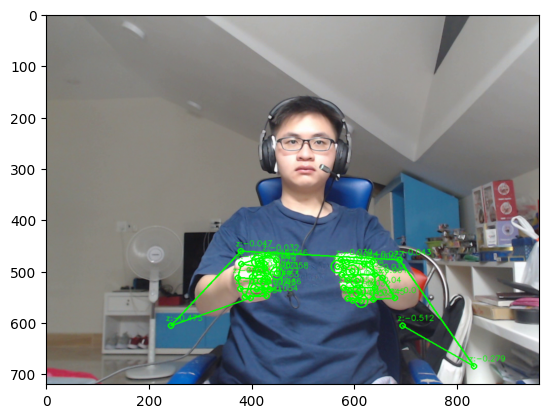

In [46]:
plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))

In [272]:
# draw_landmarks(frame, results)

In [270]:
# plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Values

In [48]:
pose = []
for index, landmark in enumerate(results.pose_landmarks.landmark):
    if index in included_landmarks:
        print(index, " - ", landmark, '\n', '---')
        pose.append([landmark.x, landmark.y, landmark.z, landmark.visibility])

11  -  x: 0.7168896
y: 0.6651891
z: -0.043094676
visibility: 0.9990746
 
 ---
12  -  x: 0.39492655
y: 0.64059204
z: -0.047454648
visibility: 0.99888474
 
 ---
13  -  x: 0.8679372
y: 0.95275116
z: -0.27859643
visibility: 0.714029
 
 ---
14  -  x: 0.253861
y: 0.8430307
z: -0.47541708
visibility: 0.75010246
 
 ---
15  -  x: 0.72329986
y: 0.84238535
z: -0.51215243
visibility: 0.82257277
 
 ---
16  -  x: 0.41507605
y: 0.7673333
z: -1.0835589
visibility: 0.8743752
 
 ---


In [49]:
len(pose)

6

In [51]:
pose_flatten = np.copy(pose).flatten()

In [52]:
pose_flatten

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522])

In [53]:
np.zeros(6 * 4)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [55]:
(6*4 + 21*3 + 21*3) * 30

4500

In [82]:
# We will only be taking the landmarks of Shoulders + Arms + Wrists + 2 Hands
def extract_keypoints_v2(results):
    pose = []
    lh = []
    rh = []
    # Pose Landmarks
    if results.pose_landmarks:
        for index, landmark in enumerate(results.pose_landmarks.landmark):
            if index in included_landmarks:
                pose = np.append(pose, [landmark.x, landmark.y, landmark.z, landmark.visibility])
                # This will be flattened upon appending
    else:
        pose = np.zeros(6*4)
    # Left Hand Landmarks
    if results.left_hand_landmarks:
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else:
        lh = np.zeros(21*3)
    # Right Hand Landmarks
    if results.right_hand_landmarks:
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:
        rh = np.zeros(21*3)

    return np.concatenate([pose, lh, rh])
        

In [83]:
np.set_printoptions(suppress=True)

In [61]:
extract_keypoints_v2(results)

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522,  0.70831358,
        0.76679593, -0.00000014,  0.68256032,  0.71336979,  0.00104126,
        0.64562964,  0.67607707, -0.00621779,  0.61082327,  0.66959381,
       -0.01395931,  0.59130645,  0.68219125, -0.02143147,  0.6616956 ,
        0.66996658, -0.02742231,  0.59885287,  0.66526049, -0.03936275,
        0.60435206,  0.68710166, -0.03925093,  0.62118268,  0.69507235,
       -0.03753251,  0.66720665,  0.70526999, -0.03438016,  0.60049641,
        0.70481569, -0.04624613,  0.61192399,  0.72015262, -0.041039  ,
        0.63091248,  0.72093767, -0.03741381,  0.66755819,  0.73935544,
       -0.04005786,  0.60416198,  0.73934424, -0.05041449,  0.61

In [62]:
np.save('0', extract_keypoints_v2(results))

In [63]:
np.load('0.npy')

array([ 0.71688962,  0.66518909, -0.04309468,  0.99907458,  0.39492655,
        0.64059204, -0.04745465,  0.99888474,  0.86793721,  0.95275116,
       -0.27859643,  0.71402901,  0.25386101,  0.84303069, -0.47541708,
        0.75010246,  0.72329986,  0.84238535, -0.51215243,  0.82257277,
        0.41507605,  0.76733333, -1.08355892,  0.87437522,  0.70831358,
        0.76679593, -0.00000014,  0.68256032,  0.71336979,  0.00104126,
        0.64562964,  0.67607707, -0.00621779,  0.61082327,  0.66959381,
       -0.01395931,  0.59130645,  0.68219125, -0.02143147,  0.6616956 ,
        0.66996658, -0.02742231,  0.59885287,  0.66526049, -0.03936275,
        0.60435206,  0.68710166, -0.03925093,  0.62118268,  0.69507235,
       -0.03753251,  0.66720665,  0.70526999, -0.03438016,  0.60049641,
        0.70481569, -0.04624613,  0.61192399,  0.72015262, -0.041039  ,
        0.63091248,  0.72093767, -0.03741381,  0.66755819,  0.73935544,
       -0.04005786,  0.60416198,  0.73934424, -0.05041449,  0.61

In [6]:
#UNUSED
# def extract_keypoints(results):
#     pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
#     face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
#     lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
#     rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
#     return np.concatenate([pose, face, lh, rh])

# Data collection

### Setting up folders

In [157]:
#DATA COLLECTION

# data_path = os.path.join('MP_Data')
data_path = "K:/Pycharm/NLN/_holistics/__DATASET_TEMP/_LandmarkData"

# Sign Language Actions used for detection
actions = np.array(["Idle", "StaticStraight", "LSteer", "RSteer", "Boost", "Brake", "BrakeHold"])
# actions = np.array(["BrakeHold"])

# Data videos for each class and frames in each video
sequence_perclass = 100
sequence_length = 30

In [153]:
# Create folders for each class

for action in actions: 
    for sequence in range(sequence_perclass):
        try: 
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except:
            pass

In [85]:
# Run again if needed
cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = True

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

True

In [86]:
# Run again if needed
# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

In [ ]:
# FPS Calc Module
cvFpsCalc = CvFpsCalc(buffer_len=10)

### Data collection

In [156]:
# Data Collection (1st snippet)

cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = True

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

start = 0

for action in actions:
    for sequence in range(80, 100):
        for frame_num in range(sequence_length):
            # display_fps = cvFpsCalc.get()
            
            # Camera Capture #####################################################
            ret, image = cap.read()
            if not ret:
                break
            image = cv.flip(image, 1)  # ミラー表示
            debug_image = copy.deepcopy(image)
            
            # Holistics Processing #############################################################
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            
            image.flags.writeable = False
            results = holistic.process(image)
            image.flags.writeable = True
            
            pose_landmarks = results.pose_landmarks
            if pose_landmarks is not None:
                # 外接矩形の計算
                brect = calc_bounding_rect(debug_image, pose_landmarks)
                # 描画
                debug_image = draw_pose_landmarks_v2(
                    debug_image,
                    pose_landmarks
                )
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            
            # Hands ###############################################################
            left_hand_landmarks = results.left_hand_landmarks
            right_hand_landmarks = results.right_hand_landmarks
            # 左手
            if left_hand_landmarks is not None:
                brect = calc_bounding_rect(debug_image, left_hand_landmarks)
                
                debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            # 右手
            if right_hand_landmarks is not None:
                
                brect = calc_bounding_rect(debug_image, right_hand_landmarks)
                
                debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
                debug_image = draw_bounding_rect(use_brect, debug_image, brect)
            
            # FPS表示
            # fps_color = (0, 255, 0)
            # cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
            #            cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)
            
            # Data Collection Logic ######################################################
            if frame_num == 0: 
                cv.putText(debug_image, 'STARTING COLLECTION', (120,180), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv2.LINE_AA)
                cv.putText(debug_image, 'Class - {}, Sequence Number {}'.format(action, sequence), (15,12), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                cv.imshow('Data Collection Module', debug_image)
                cv.waitKey(2000)
            else: 
                cv.putText(debug_image, 'Class - {}, Sequence Number {}'.format(action, sequence), (15,12), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                cv.imshow('Data Collection Module', debug_image)
            
            # Export Holistics Keypoints Data for each frame
            keypoints = extract_keypoints_v2(results)
            npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
            np.save(npy_path, keypoints)
            
            # キー処理(ESC：終了) #################################################
            key = cv.waitKey(10)
            if key == 27:  # ESC
                break
            
            # 画面反映 #############################################################
            # cv.imshow('Data Collection Module', debug_image)

cap.release()
cv.destroyAllWindows()

In [98]:
####collections of video sequences for each gesture (2nd snippet)

start = 0

cap = cv2.VideoCapture(0)

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for sequence in range(start, 5):
            for frame_num in range(sequence_length):
                
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, holistic)
                draw_landmarks(image, results)
                
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Class - {}, Sequence Number {}'.format(sign, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(4000)
                else: 
                    cv2.putText(image, 'Class - {}, Sequence Number {}'.format(sign, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                
                # Export Holistics Keypoints Data for each frame
                keypoints = extract_keypoints_v2(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [103]:
    cap.release()
    cv2.destroyAllWindows()

In [105]:
# Reading test (IDLE Action)
np.load(os.path.join(data_path, "Idle", "99", "29.npy"))

array([ 0.65844977,  0.61443746, -0.28758794,  0.99967563,  0.35558844,
        0.60657746, -0.40073171,  0.9999193 ,  0.7316348 ,  0.95488411,
       -0.13574722,  0.77001089,  0.27005249,  0.92011809, -0.33331186,
        0.79169321,  0.77772176,  1.2318294 , -0.28651211,  0.09750269,
        0.21927863,  1.18768072, -0.58644634,  0.24825162,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

# Preprocess Data + Creating Labels and Features

In [158]:
# Imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [159]:
# Label dictionary
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}

In [160]:
sequences, labels = [], []
for action in actions:
    # Every action has 100 sequences, each sequence are at 30fps
    for sequence in range(sequence_perclass):
        window = []
        # Window will be a list containing 30 frames' worth of landmarks, with each frame in its own array
        # Simply put, [[24+126], [24+126],... [24+126]]
        # We load from them npy files and then we append it to Window list
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [161]:
np.array(sequences).shape

(700, 30, 150)

In [162]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,


In [163]:
np.array(labels).shape

(700,)

In [164]:
X = np.array(sequences)
X.shape

# y = to_categorical(labels).astype(int)

(700, 30, 150)

In [167]:
y = np.array(labels)
y.shape

(700,)

In [252]:
#Train/Test/Val Split
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

# Test and Val split
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [189]:
X_train.shape

(490, 30, 150)

In [170]:
X_val.shape

(105, 30, 150)

In [171]:
X_test.shape

(105, 30, 150)

In [176]:
actions.shape

(7,)

In [177]:
actions.shape[0]

7

In [253]:
#define LSTM model
NUM_OF_GESTURES = actions.shape[0]

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

# Input shape is a sequence consisting of 30 frames, with each frame having 150 landmarks
inputs = Input(shape=(30, 150))
x = LSTM(64, return_sequences=True, activation='relu')(inputs)
x = LSTM(128, return_sequences=True, activation='relu')(x)
x = LSTM(64, return_sequences=False, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
prediction = Dense(NUM_OF_GESTURES, activation='softmax')(x)
# Last dense layer (pred. layer) contains 7 nodes, for 7 corresponding gestures

model = Model(inputs=inputs, outputs=prediction)

model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 30, 150)]         0         
                                                                 
 lstm_30 (LSTM)              (None, 30, 64)            55040     
                                                                 
 lstm_31 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_32 (LSTM)              (None, 64)                49408     
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 7)                 231

In [254]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [255]:
# es = EarlyStopping(min_delta = 0.05, mode='min', patience = 20, restore_best_weights=True)
es = EarlyStopping(min_delta = 0.05, patience = 20)
# es = EarlyStopping(patience = 20, verbose=1)

In [256]:
#train LSTM model

import time

start = time.time()

history = model.fit(X_train, 
                    y_train, 
                    validation_data=(X_val, y_val), 
                    epochs=500,
                    callbacks=[es]) 

print('Time to train: {}s'.format(time.time() - start))

Epoch 1/500
16/16 [==============================] - 5s 63ms/step - loss: 1.8642 - accuracy: 0.2469 - val_loss: 1.5621 - val_accuracy: 0.4762
Epoch 2/500
16/16 [==============================] - 1s 36ms/step - loss: 1.7718 - accuracy: 0.3449 - val_loss: 1.5072 - val_accuracy: 0.3143
Epoch 3/500
16/16 [==============================] - 1s 36ms/step - loss: 1.5542 - accuracy: 0.2796 - val_loss: 1.3282 - val_accuracy: 0.3714
Epoch 4/500
16/16 [==============================] - 1s 36ms/step - loss: 2.6938 - accuracy: 0.4000 - val_loss: 1.2397 - val_accuracy: 0.3905
Epoch 5/500
16/16 [==============================] - 1s 36ms/step - loss: 1.6864 - accuracy: 0.3143 - val_loss: 1.7769 - val_accuracy: 0.2571
Epoch 6/500
16/16 [==============================] - 1s 36ms/step - loss: 1.7377 - accuracy: 0.2714 - val_loss: 1.6121 - val_accuracy: 0.3429
Epoch 7/500
16/16 [==============================] - 1s 36ms/step - loss: 1.6415 - accuracy: 0.3020 - val_loss: 1.6052 - val_accuracy: 0.3333
Epoch 

Train: 0.953, Validation: 0.971


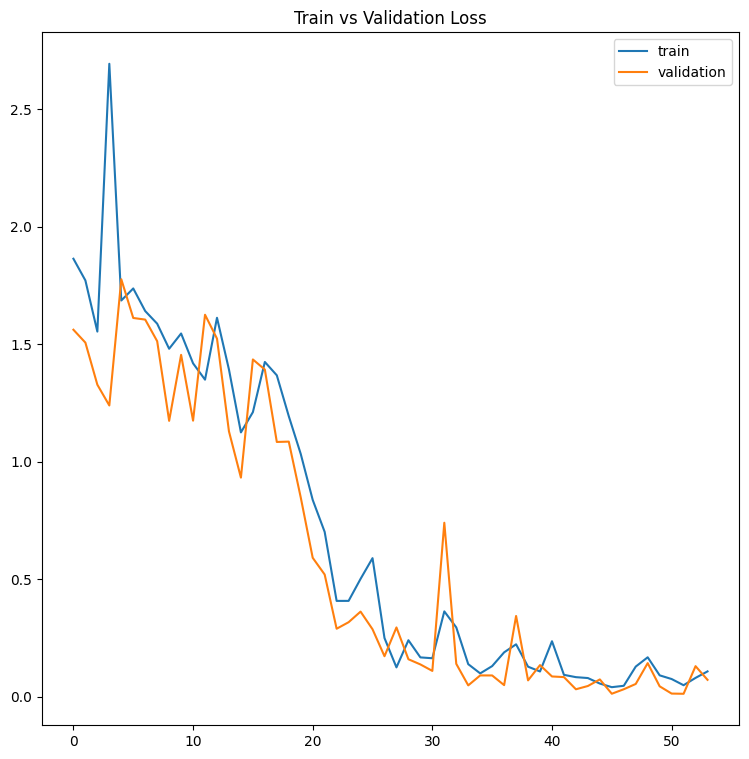

In [257]:
import matplotlib.pyplot as plt

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

# plot loss history
plt.figure(figsize=(9,9))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

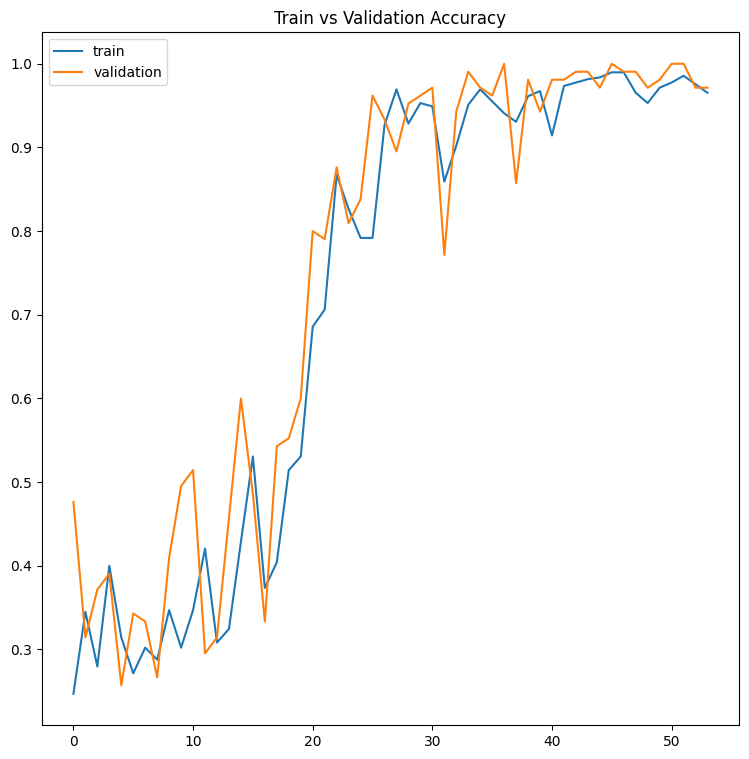

In [258]:
# plot accuracy history
plt.figure(figsize=(9,9))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.show()

In [260]:
model.save('lstm_action_recog.keras')

In [261]:
model.load_weights('lstm_action_recog.keras')

4/4 [==============================] - 0s 11ms/step


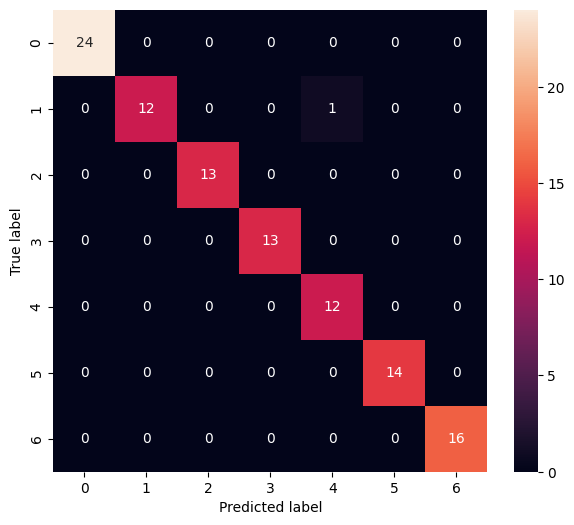

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      0.92      0.96        13
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00        13
           4       0.92      1.00      0.96        12
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        16

    accuracy                           0.99       105
   macro avg       0.99      0.99      0.99       105
weighted avg       0.99      0.99      0.99       105



In [266]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

'''
{'Idle': 0,
 'StaticStraight': 1,
 'LSteer': 2,
 'RSteer': 3,
 'Boost': 4,
 'Brake': 5,
 'BrakeHold': 6}
'''


In [267]:
# from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix

# ypred = model.predict(X_test)
# ytrue = np.argmax(y_test, axis=0)
# ypred = np.argmax(ypred, axis=1)

# accuracy_score(ytrue, ypred)

In [268]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import itertools

# def plot_confusion_matrix(cm,
#                           target_names,
#                           title='Confusion matrix',
#                           cmap=None,
#                           normalize=False):
#     #Citiation
#     #---------
#     #http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

#     accuracy = np.trace(cm) / float(np.sum(cm))
#     misclass = 1 - accuracy

#     if cmap is None:
#         cmap = plt.get_cmap('Blues')

#     plt.figure(figsize=(8, 6))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()

#     if target_names is not None:
#         tick_marks = np.arange(len(target_names))
#         plt.xticks(tick_marks, target_names, rotation=45)
#         plt.yticks(tick_marks, target_names)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


#     thresh = cm.max() / 1.5 if normalize else cm.max() / 2
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         if normalize:
#             plt.text(j, i, "{:0.4f}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")
#         else:
#             plt.text(j, i, "{:,}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")


#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.show()

In [269]:
# cm = confusion_matrix(ytrue, ypred)

# plot_confusion_matrix(cm, signs, cmap='Reds')

# Test in Real Time

In [14]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)

width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# writer= cv2.VideoWriter('livefeed_test.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 20, (width,height))

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()

        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        draw_landmarks(image, results)
        
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(signs[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:
                    cv2.putText(image, signs[np.argmax(res)], (0, 45), cv2.FONT_HERSHEY_PLAIN, 1.5, (255,255,255), 1, cv2.LINE_AA)
        # writer.write(image)
        cv2.imshow('Live Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    writer.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
thank_you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thank_you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thank_you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thank_you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
thank_you
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<class 'mediapipe.python.solution_base.SolutionOutputs'>
no
<clas

<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'>
hello
<class 'mediapipe.python.solution_base.SolutionOutputs'

# Test

In [293]:
cap_device = 0
cap_width = 960
cap_height = 720

smooth_landmarks = False
enable_segmentation = False
smooth_segmentation = False
model_complexity = 1
min_detection_confidence = 0.5
min_tracking_confidence = 0.5

use_brect = False

# Camera Preps
cap = cv.VideoCapture(cap_device)
cap.set(cv.CAP_PROP_FRAME_WIDTH, cap_width)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, cap_height)

# Mediapipe
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(
    model_complexity=model_complexity,
    smooth_landmarks=smooth_landmarks,
    enable_segmentation=enable_segmentation,
    smooth_segmentation=smooth_segmentation,
    min_detection_confidence=min_detection_confidence,
    min_tracking_confidence=min_tracking_confidence,
)

# Prediction vars
model.load_weights('lstm_action_recog.keras')
pred_sequence = []
current_action = ""
predictions = []
action_list = []
pred_threshold = 0.5

while True:
    display_fps = cvFpsCalc.get()

    # Camera Capture #####################################################
    ret, image = cap.read()
    if not ret:
        break
    image = cv.flip(image, 1)  # ミラー表示
    debug_image = copy.deepcopy(image)

    # Holistics Processing #############################################################
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    image.flags.writeable = False
    results = holistic.process(image)
    image.flags.writeable = True

    pose_landmarks = results.pose_landmarks
    if pose_landmarks is not None:
        # 外接矩形の計算
        brect = calc_bounding_rect(debug_image, pose_landmarks)
        # 描画
        debug_image = draw_pose_landmarks_v2(
            debug_image,
            pose_landmarks
        )
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # Hands ###############################################################
    left_hand_landmarks = results.left_hand_landmarks
    right_hand_landmarks = results.right_hand_landmarks
    # 左手
    if left_hand_landmarks is not None:
        brect = calc_bounding_rect(debug_image, left_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, left_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)
    # 右手
    if right_hand_landmarks is not None:
        
        brect = calc_bounding_rect(debug_image, right_hand_landmarks)
        
        debug_image = draw_hand_v2(debug_image, results.right_hand_landmarks)
        debug_image = draw_bounding_rect(use_brect, debug_image, brect)

    # FPS表示
    fps_color = (0, 255, 0)
    cv.putText(debug_image, "FPS:" + str(display_fps), (10, 30),
               cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)

    # Prediction Logic
    # keypoints is solely used for containing extracted landmarks
    keypoints = extract_keypoints_v2(results)
    # Append keypoint array constantly, until we reach at least 30 frames
    pred_sequence.append(keypoints)
    # Take the last 30 frames, if we have 0-29 30 31 then it'd take 2-31 for prediction
    pred_sequence = pred_sequence[-30:]

    # if len(pred_sequence) == 30:
    res = model.predict(np.expand_dims(pred_sequence, axis=0))[0]
    print(actions[np.argmax(res)])
    predictions.append(np.argmax(res))
    
    # Visualization
    if np.unique(predictions[-20:])[0]==np.argmax(res):
        if res[np.argmax(res)] > pred_threshold:
            current_action = actions[np.argmax(res)]

            # Testing (it's almost 6am spare me from this)
            if len(action_list) > 0:
                action_list.append(actions[np.argmax(res)])
                # if actions[np.argmax(res)] == 'LSteer' and action_list[-1] == 'RSteer':
                #     current_action = 'StaticStraight'
                # if actions[np.argmax(res)] == 'RSteer' and action_list[-1] == 'LSteer':
                #     current_action = 'StaticStraight'
            else:
                action_list.append(actions[np.argmax(res)])

    if len(action_list) > 5:
        action_list = action_list[-5:]
    
                
    cv.putText(debug_image, "Gesture:" + current_action, (10, 70),
           cv.FONT_HERSHEY_SIMPLEX, 1.0, fps_color, 2, cv.LINE_AA)
    
    # キー処理(ESC：終了) #################################################
    key = cv.waitKey(1)
    if key == 27:  # ESC
        break

    # 画面反映 #############################################################
    cv.imshow('MediaPipe Holistic Demo', debug_image)

cap.release()
cv.destroyAllWindows()

1/1 [==============================] - 0s 15ms/step
BrakeHold
1/1 [==============================] - 0s 11ms/step
BrakeHold
1/1 [==============================] - 0s 10ms/step
BrakeHold
1/1 [==============================] - 0s 9ms/step
BrakeHold
1/1 [==============================] - 0s 10ms/step
BrakeHold
1/1 [==============================] - 0s 10ms/step
BrakeHold
1/1 [==============================] - 0s 11ms/step
BrakeHold
1/1 [==============================] - 0s 11ms/step
BrakeHold
1/1 [==============================] - 0s 11ms/step
BrakeHold
1/1 [==============================] - 0s 9ms/step
BrakeHold
1/1 [==============================] - 0s 10ms/step
BrakeHold
1/1 [==============================] - 0s 11ms/step
BrakeHold
1/1 [==============================] - 0s 10ms/step
BrakeHold
1/1 [==============================] - 0s 10ms/step
BrakeHold
1/1 [==============================] - 0s 10ms/step
BrakeHold
1/1 [==============================] - 0s 10ms/step
BrakeHold
1/1 [=====

In [275]:
    cap.release()
    cv2.destroyAllWindows()